In [1]:
combinedInputPath = "/mnt/SPDrive/SPGenerations/" #The path to the folder containing the tokenized and graded data. If individualInput is true, this will be ignored

individualInput = False #If true, the program will use the individual input paths below. If false, it will use the combinedInputPath above
pathToTokenizedData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Tokenizer\\"
pathToGradeData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Grader\\"

GradesTokensName = "" #Specifiy the versions (name) of the grade and token files to use. Leave blank to use the newest version

modelOutputPath = "/mnt/SPDrive/SPGenerations/Models/" #The path to the folder for the model output.

import os
def homePath(path):
    if path[0] == "~":
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

if not individualInput:
    pathToTokenizedData = os.path.join(combinedInputPath, "Tokens/")
    pathToGradeData = os.path.join(combinedInputPath, "Grades/")

if GradesTokensName == "":
    #Use newest folder for each

    #Get the newest folder for the tokens
    tokensFolders = os.listdir(pathToTokenizedData)
    tokensFolders.sort()
    pathToTokenizedData = os.path.join(pathToTokenizedData , tokensFolders[-1])

    #Get the newest folder for the grades
    gradesFolders = os.listdir(pathToGradeData)
    gradesFolders.sort()
    pathToGradeData = os.path.join(pathToGradeData,  gradesFolders[-1])
else:
    pathToTokenizedData = os.path.join(pathToTokenizedData, GradesTokensName)
    pathToGradeData = os.path.join(pathToGradeData, GradesTokensName)








In [2]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional, Input, Flatten, Concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras.layers as layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model




from keras.utils import pad_sequences
import os



#Load the data
#tokenized data is in tokenizedData.pkl, has tokenizer obj in tokenizer.json

#Load the tokenizer
with open(pathToTokenizedData+ "/tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())



#Load the tokenized data
with open(pathToTokenizedData + "/tokenizedData.pkl", "rb") as f:
    tokenizedData = pickle.load(f)

#Load the grade data
#gradeData is a dict with keys as the file names and values as the grades
with open(pathToGradeData + "/grades.pkl", "rb") as f:
    gradeData = pickle.load(f)

#load the group data
#with open(pathToTokenizedData + "/tokenGroupDataframe.pkl", "rb") as f:
#    tokenizedGroupData = pickle.load(f)

combinedDF = pd.merge(tokenizedData, gradeData, on = "Path")
#combinedDF = pd.merge(combinedDF, tokenizedGroupData, on = "Path")
print (combinedDF)







2024-02-13 06:01:03.325612: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 06:01:03.360939: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 06:01:03.360965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 06:01:03.360996: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 06:01:03.368211: I tensorflow/core/platform/cpu_feature_g

                                                tokenCode  \
0       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
1       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
2       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
3       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
4       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
...                                                   ...   
180568  [44, 422, 28, 1, 28, 79, 4, 24, 10, 3, 9, 3, 4...   
180569  [44, 284, 28, 284, 28, 1, 28, 266, 44, 1, 28, ...   
180570  [28, 682, 44, 284, 28, 284, 28, 1, 28, 266, 44...   
180571  [44, 284, 28, 284, 28, 1, 28, 266, 44, 1, 28, ...   
180572  [28, 682, 44, 284, 28, 284, 28, 1, 28, 266, 44...   

                                                     Path  fileGrade  
0       3722273/examples/basics/linear_regression.py/1.py  59.000000  
1       3722273/examples/basics/linear_regression.py/2.py  66.000000  
2       3722273/examples/basics/linear_regression.py/3

In [3]:
rungraph = False
if rungraph:
    #chart of token length vs grade
    tokenLengths = combinedDF["tokenCode"].apply(lambda x: len(x))
    plt.scatter(tokenLengths, combinedDF["fileGrade"])
    plt.xlabel("Token Length")
    plt.ylabel("Grade")
    plt.show()


    #graph the density of the grades vs length
    count = []
    countLow = []
    countHigh = []
    for i in range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1):
        count.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].mean())
        countLow.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].quantile(.25))
        countHigh.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].quantile(.75))

                    

    plt.scatter(range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1), count)
    #draw a line of best fit
    z = np.polyfit(range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1), count, 1)
    p = np.poly1d(z)
    plt.xlabel("Token Length")
    plt.ylabel("Grade")
    plt.show()







In [4]:
#Padding

maxLen = 500
minLen = 100
#get rid of the ones that are too long
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]

#shorten the ones that are too long
#combinedDF["tokenCode"] = combinedDF["tokenCode"].apply(lambda x: x[:maxLen])
#combinedDF = combinedDF[combinedDF["tokenGroupCode"].apply(lambda x: len(x)) <= maxLen]
 

#get rid of the ones that are too short
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) > minLen]
#combinedDF = combinedDF[combinedDF["tokenGroupCode"].apply(lambda x: len(x)) > minLen]

#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()
#combinedDF["tokenGroupCode"] = pad_sequences(combinedDF["tokenGroupCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

print (combinedDF)

#only use 5% of the dat
#combinedDF = combinedDF.sample(frac = 0.001, random_state = 1)

#48590 



                                                tokenCode  \
0       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
1       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
2       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
3       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
4       [22, 9, 22, 44, 422, 28, 612, 6, 742, 6, 639, ...   
...                                                   ...   
180559  [44, 422, 28, 1, 28, 79, 4, 24, 10, 3, 9, 3, 4...   
180561  [44, 422, 28, 1, 28, 79, 4, 24, 10, 3, 9, 3, 4...   
180564  [44, 422, 28, 1, 28, 266, 28, 79, 4, 24, 10, 3...   
180565  [44, 422, 28, 1, 4, 24, 10, 3, 9, 3, 4, 25, 10...   
180568  [44, 422, 28, 1, 28, 79, 4, 24, 10, 3, 9, 3, 4...   

                                                     Path  fileGrade  
0       3722273/examples/basics/linear_regression.py/1.py  59.000000  
1       3722273/examples/basics/linear_regression.py/2.py  66.000000  
2       3722273/examples/basics/linear_regression.py/3

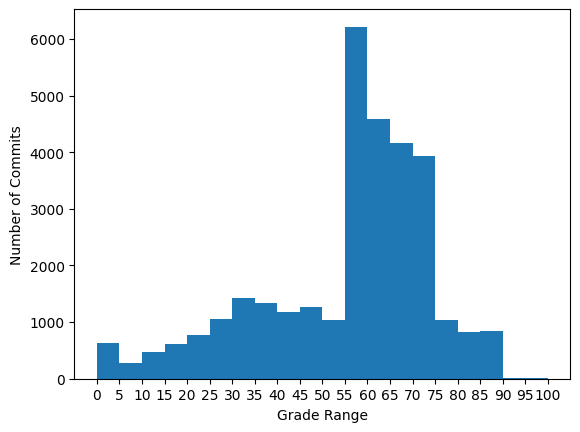

In [5]:
#create a chart of the grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()



In [6]:
#if (not gpu_detected):
#    print("GPU not detected, using CPU")


#Create the model
#Input
inputTokens = layers.Input(shape=(maxLen,), dtype='int32')

#Embedding
embedding = layers.Embedding(tokenizer.num_words, 2048, input_length=maxLen)(inputTokens)

#Convolutional
convolutional = layers.Conv1D(2048, 3, activation='relu')(embedding)
convolutional = layers.GlobalMaxPooling1D()(convolutional)
convolutional = layers.Reshape((1, 2048))(convolutional)

#LSTM
lstm = layers.Bidirectional(LSTM(1024, return_sequences=True))(convolutional)
lstm = Dropout(0.38479930887149405)(lstm)
lstm = layers.Bidirectional(LSTM(512))(lstm)

#Dense
dense = layers.Flatten()(lstm)
dense = layers.Dense(4096, activation='relu')(dense)
dense = layers.Dense(2048, activation='relu')(dense)
dense = layers.Dense(1, activation='relu')(dense)

#Output
output = dense


model = Model(inputs=inputTokens, outputs=output)



print(model.summary())

model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'accuracy'])





# convert inputs to numpy arrays
token_code = np.array(combinedDF["tokenCode"].tolist())
file_grade = np.array(combinedDF["fileGrade"].tolist())
#convert file_grade to floats from strings
file_grade = np.array(list(map(float, file_grade)))




hist = model.fit(token_code, file_grade, epochs=100, batch_size=32, verbose=1)


#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now()).replace(" ", "_").replace(":", "-").replace(".", "-")
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
#make an archaive of the SCA-Tokenizer Folder
#get CWD
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer")):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/SCA-Tokenizer.tar.gz\" " + os.path.join(cwd, "SCA-Tokenizer"))

#Save the AutoGrader Folder
autoGraderDir = os.path.join(cwd, "../Auto-Grader/")
if os.path.exists(autoGraderDir):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/Auto-Grader.tar.gz\" " + autoGraderDir)

#Save tokenizedGroupData
#copy GroupDict.npy from the tokenizer folder to the model folder
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer", "GroupDict.npy")):
    os.system("cp " + os.path.join(cwd, "SCA-Tokenizer", "GroupDict.npy") + " " + os.path.join(modelOutputPath, timestamp, "GroupDict.npy"))





2024-02-13 06:01:22.453011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13173 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:11:00.0, compute capability: 8.6
2024-02-13 06:01:22.454008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13173 MB memory:  -> device: 1, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6
2024-02-13 06:01:23.573739: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 2048)         1638400   
                                                                 
 conv1d (Conv1D)             (None, 498, 2048)         12584960  
                                                                 
 global_max_pooling1d (Glob  (None, 2048)              0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 bidirectional (Bidirection  (None, 1, 2048)           25174016  
 al)                                                         

2024-02-13 06:01:33.595186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-13 06:01:34.262950: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-13 06:01:39.787818: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f83642e3310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-13 06:01:39.787840: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2024-02-13 06:01:39.787843: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A2, Compute Capability 8.6
2024-02-13 06:01:39.791718: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-13 06:01:39.899353: I ./tensorflow/compiler/jit/device_compiler.h:186] Co

993/993 [==============================] - 258s 237ms/step - loss: 0.3234 - mse: 409.2336 - mae: 15.4743 - mape: 246218592.0000 - accuracy: 1.5750e-04
Epoch 2/100
993/993 [==============================] - 234s 236ms/step - loss: 0.1790 - mse: 235.0692 - mae: 11.9973 - mape: 79720944.0000 - accuracy: 0.0000e+00
Epoch 3/100
993/993 [==============================] - 235s 236ms/step - loss: 0.1741 - mse: 228.0331 - mae: 11.7261 - mape: 79631064.0000 - accuracy: 0.0000e+00
Epoch 4/100
993/993 [==============================] - 235s 237ms/step - loss: 0.1584 - mse: 210.0208 - mae: 11.2040 - mape: 61262268.0000 - accuracy: 0.0000e+00
Epoch 5/100
993/993 [==============================] - 235s 237ms/step - loss: 0.1572 - mse: 207.4631 - mae: 11.1418 - mape: 56081224.0000 - accuracy: 0.0000e+00
Epoch 6/100
993/993 [==============================] - 235s 237ms/step - loss: 0.1468 - mse: 199.2506 - mae: 10.8402 - mape: 47524572.0000 - accuracy: 3.1499e-05
Epoch 7/100
993/993 [==================

/home/mcall/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/TokenizerManager.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/CaMlSupportingClasses.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/PythonProcessing.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CaMlSupportingClasses.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CodeSimilarization.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/PythonProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/TokenProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/TokenProcessing.py
/home/mcall/SP

tar: Removing leading `/' from member names
tar: Removing leading `/home/mcall/SPGit/Model-Generation/../' from member names
